In [1]:
from __future__ import print_function
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import numpy as np
import glob
from moltraffic.visualisations import station_error_boxplot, error_distribution, mean_error_over_time, \
    error_distribution_over_time, actual_vs_predicted_series


def get_daily_prediction_errors(predictions_file):
    df = pd.read_csv(predictions_file, compression='gzip')
    df['Time'] = pd.to_datetime(df['Time'])

    columns_pred = [x.replace('_pred', '') for x in df.columns if x.endswith('_pred')]
    columns_actual = [x.replace('_actual', '') for x in df.columns if x.endswith('_actual')]

    columns = sorted(list(set(columns_pred).intersection(set(columns_actual))))
    diff_columns = []
    for c in columns:
        df[f'{c}_diff'] = (df[f'{c}_pred'] - df[f'{c}_actual']).abs()
        diff_columns.append(f'{c}_diff')
    df_diff = df[['Time'] + [x for x in df.columns if x.endswith('_diff')]].copy()
    
    df_diff['dayofyear'] = df_diff.Time.dt.dayofyear
    
    sum_df = df_diff.dropna(axis='columns').groupby('dayofyear').mean()
    y = list(sum_df.mean(axis=1))
    
    return y

def mean_multiple(glob_file_expresion):
    y = []
    files = glob.glob(glob_file_expresion)
    for file in files:

        yc = get_daily_prediction_errors(files[0])
        y.append(yc)

    y = np.array(y)
    y = np.mean(y, axis=0)
    
    return y

In [2]:
model_name = 'PytorchWideWideDeepEnsemble10RegressorModel'
run='*'

In [3]:
def get_daily_relative_prediction_errors(predictions_file):
    df = pd.read_csv(predictions_file, compression='gzip')
    df['Time'] = pd.to_datetime(df['Time'])

    columns_pred = [x.replace('_pred', '') for x in df.columns if x.endswith('_pred')]
    columns_actual = [x.replace('_actual', '') for x in df.columns if x.endswith('_actual')]

    columns = sorted(list(set(columns_pred).intersection(set(columns_actual))))
    diff_columns = []
    for c in columns:
        df[f'{c}_diff'] = (df[f'{c}_pred'] - df[f'{c}_actual']).abs()
        diff_columns.append(f'{c}_diff')
    df_diff = df[['Time'] + [x for x in df.columns if x.endswith('_diff')]].copy()
    df_diff['dayofyear'] = df_diff.Time.dt.dayofyear

    df_actual = df[['Time'] + [x for x in df.columns if x.endswith('_actual')]].copy()
    df_actual['dayofyear'] = df_actual.Time.dt.dayofyear

    M_diff = df_diff.groupby('dayofyear').mean().to_numpy()
    M_true = df_actual.groupby('dayofyear').mean().to_numpy()+1

    M_ratio = (M_diff/M_true)
    y = np.nanmedian(M_ratio, axis=1)
    return y

def mean_multiple(glob_file_expresion):
    y = []
    files = glob.glob(glob_file_expresion)
    for file in files:
        yc = get_daily_relative_prediction_errors(file)
        y.append(yc)

    y = np.array(y)
    y = np.mean(y, axis=0)
    
    return y

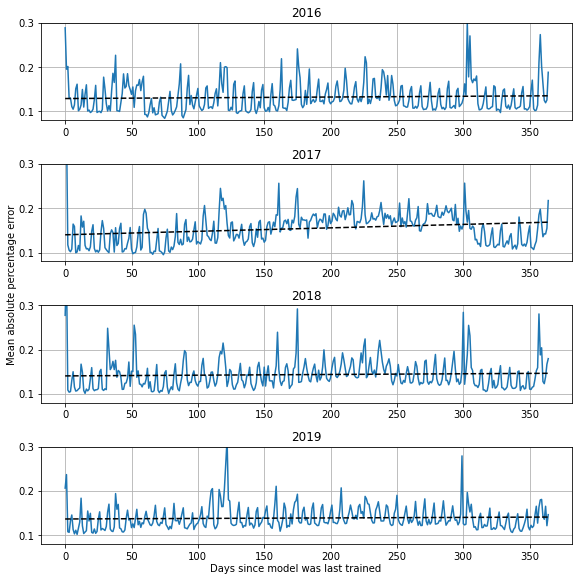

In [4]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8))

y = mean_multiple(f'../models/test_predictions/{model_name}/subset_1_1_2016_run_{run}.csv')
x = range(len(y))
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
axs[0].plot(x, y)
axs[0].plot(x, poly1d_fn(x), '--k')

y = mean_multiple(f'../models/test_predictions/{model_name}/subset_1_1_2017_run_{run}.csv')
x = range(len(y))
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
axs[1].plot(x, y)
axs[1].plot(x, poly1d_fn(x), '--k')

y = mean_multiple(f'../models/test_predictions/{model_name}/subset_1_1_2018_run_{run}.csv')
x = range(len(y))
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
axs[2].plot(x, y)
axs[2].plot(x, poly1d_fn(x), '--k')

y = mean_multiple(f'../models/test_predictions/{model_name}/subset_1_1_2019_run_{run}.csv')
x = range(len(y))
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
axs[3].plot(x, y)
axs[3].plot(x, poly1d_fn(x), '--k')

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)
axs[3].grid(True)

y_lim = [0.08, 0.3]
axs[0].set_ylim(y_lim)
axs[1].set_ylim(y_lim)
axs[2].set_ylim(y_lim)
axs[3].set_ylim(y_lim)

axs[0].set_title('2016')
axs[1].set_title('2017')
axs[2].set_title('2018')
axs[3].set_title('2019')

fig.tight_layout()

fig.text(0.0, 0.5, 'Mean absolute percentage error', va='center', rotation='vertical')
fig.text(0.5, 0.00, 'Days since model was last trained', ha='center')

plt.savefig(f'relative_data_drift.pdf', bbox_inches='tight', pad_inches=0)